In [271]:
import pandas as pd
from functools import reduce

Vamos clusterizar cidades baseados em número de habitantes, arrecadação e IDH, para que possamos usar dados de cidades similares para construir modelos.

# Passo 1: construção da base de dados

_OBS: Se você já rodou esse passo uma vez e gerou a base de dados em .csv na pasta **data/**, já pode pular para o segundo passo!_

Primeiramente, carregamos e extraímos os dados de arrecadação do TCE-SP. Disponíveis [nesse link](https://transparencia.tce.sp.gov.br/conjunto-de-dados), em _Receitas_. Vamos nos basear no ano de 2018, pois o ano de 2019 ainda está incompleto.

In [233]:
receitas_df = pd.read_csv("../data/receitas/receitas-2018.csv", sep=";", encoding="windows-1254")

In [234]:
receitas_df["vl_arrecadacao"] = (
    receitas_df["vl_arrecadacao"]
    .apply(lambda x: float(x.replace(",", ".")))
    .astype(float)
)

In [235]:
arrecadacao_df = (
    receitas_df[["ds_municipio", "vl_arrecadacao"]]
    .groupby("ds_municipio")
    .sum()
    .reset_index()
)

In [236]:
arrecadacao_df = arrecadacao_df.rename(
    columns={"ds_municipio": "municipio", "vl_arrecadacao": "arrecadacao"}
)

In [237]:
arrecadacao_df.head()

,municipio,arrecadacao
0,Adamantina,1.668520e+08
1,Adolfo,2.581124e+07
2,Aguaí,8.606935e+07
3,Agudos,1.493109e+08
4,Alambari,2.307959e+07


Em seguida, pegamos os dados demográficos de bases variadas.

Para os dados de número de habitantes, temos disponíveis informações do Censo de 2010 [nesse link](http://catalogo.governoaberto.sp.gov.br/dataset/mapa-paulista-da-gestao-documental-e-acesso-a-informacao).

In [238]:
demografia_df = pd.read_csv(
    "../random/data/gestao_documental_paulista_prefeituras.csv",
    sep=";",
    encoding="windows-1254",
)

In [239]:
demografia_df = demografia_df[["Município", "Número de Habitantes (em 2010)"]]

In [240]:
demografia_df = demografia_df.rename(
    columns={"Município": "municipio", "Número de Habitantes (em 2010)": "habitantes"}
)

In [241]:
demografia_df["habitantes"] = (
    demografia_df["habitantes"].apply(lambda x: float(x.replace(".", ""))).astype(float)
)

Por fim, removemos a capital para se adequar à base do TCE:

In [242]:
demografia_df = demografia_df[demografia_df.municipio != "São Paulo"]

In [243]:
demografia_df.head()

,municipio,habitantes
0,Adamantina,33797.0
1,Adolfo,3557.0
2,Aguaí,32148.0
3,Águas da Prata,7584.0
4,Águas de Lindóia,17266.0


In [244]:
len(demografia_df)

644

Para os dados do IDHM, consultamos a base disponível do Atlas de Desenvolvimento Humano do Brasil, de 2013, disponível [nesse link](http://atlasbrasil.org.br/2013/pt/download/).

In [245]:
idhm_xls = pd.ExcelFile("../data/random/atlas2013_dadosbrutos_pt.xlsx")

In [246]:
idhm_df = pd.read_excel(idhm_xls, "MUN 91-00-10", encoding="windows-1254")

In [247]:
idhm_df.head()

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,...,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R
0,1991,11,110001,1100015,ALTA FLORESTA D'OESTE,62.01,4.08,45.58,58.05,73.50,...,NaN,NaN,23417,22835,0.117,0.109,0.329,0.112,0.617,0.516
1,1991,11,110002,1100023,ARIQUEMES,66.02,3.72,32.39,41.41,69.97,...,NaN,NaN,56061,55018,0.200,0.199,0.432,0.199,0.684,0.593
2,1991,11,110003,1100031,CABIXI,63.16,3.89,41.52,52.94,77.23,...,NaN,NaN,7601,5846,0.111,0.106,0.309,0.108,0.636,0.430
3,1991,11,110004,1100049,CACOAL,65.03,3.81,35.37,45.19,71.11,...,NaN,NaN,69173,66534,0.176,0.169,0.407,0.171,0.667,0.593
4,1991,11,110005,1100056,CEREJEIRAS,62.73,3.55,43.00,54.82,71.09,...,NaN,NaN,19451,19030,0.152,0.175,0.386,0.167,0.629,0.547


Como podemos observar em outra planilha do .xlsx, o código de UF para o estado de São Paulo é **35**. Além disso, selecionamos os dados mais recentes, de 2010.

In [248]:
idhm_df = idhm_df[(idhm_df.UF == 35) & (idhm_df.ANO == 2010)].reset_index()

In [249]:
idhm_df = idhm_df[["Município", "IDHM"]]

In [250]:
idhm_df = idhm_df.rename(columns={"Município": "municipio", "IDHM": "idhm"})

Função auxiliar para adequar nomes de municípios:

In [251]:
def correctly_capitalize_city_name(name):
    name = name.lower()
    prepositions = [
        "a",
        "o",
        "as",
        "os",
        "com",
        "de",
        "da",
        "do",
        "das",
        "dos",
        "ao",
        "para",
        "entre",
        "nas",
        "nos",
        "aos",
    ]
    name_list = name.split(" ")
    for idx, word in enumerate(name_list):
        if word not in prepositions:
            if "-" in word:
                word = "-".join([part.capitalize() for part in word.split("-")])
            else:
                word = word.capitalize()
            name_list[idx] = word
    return (" ").join(name_list)

In [252]:
idhm_df["municipio"] = idhm_df["municipio"].apply(correctly_capitalize_city_name)

Por fim, removemos a capital para se adequar à base do TCE:

In [253]:
idhm_df = idhm_df[idhm_df.municipio != "São Paulo"]

In [254]:
idhm_df.head()

,municipio,idhm
0,Adamantina,0.790
1,Adolfo,0.730
2,Aguaí,0.715
3,Águas da Prata,0.781
4,Águas de Lindóia,0.745


Ajustando discrepância de dados entre as bases:

In [255]:
idhm_df.at[
    (idhm_df[idhm_df.municipio == "Embu"].index[0]), "municipio"
] = "Embu das Artes"

In [256]:
idhm_df.at[
    (idhm_df[idhm_df.municipio == "Moji Mirim"].index[0]), "municipio"
] = "Mogi Mirim"

In [257]:
idhm_df.at[
    (idhm_df[idhm_df.municipio == "São Luís do Paraitinga"].index[0]), "municipio"
] = "São Luiz do Paraitinga"

In [258]:
idhm_df["municipio"] = idhm_df["municipio"].apply(
    lambda x: x.replace("D'oeste", "D'Oeste")
)

In [259]:
idhm_df["municipio"] = idhm_df["municipio"].apply(
    lambda x: x.replace("D'alho", "D'Alho")
)

In [260]:
arrecadacao_df.at[
    (arrecadacao_df[arrecadacao_df.municipio == "São Luís do Paraitinga"].index[0]),
    "municipio",
] = "São Luiz do Paraitinga"

In [261]:
arrecadacao_df["municipio"] = arrecadacao_df["municipio"].apply(
    lambda x: x.replace("d Oeste", "D'Oeste")
)

In [262]:
arrecadacao_df["municipio"] = arrecadacao_df["municipio"].apply(
    lambda x: x.replace("d Alho", "D'Alho")
)

In [263]:
demografia_df["municipio"] = demografia_df["municipio"].apply(
    lambda x: x.replace("d'Oeste", "D'Oeste")
)

In [264]:
demografia_df["municipio"] = demografia_df["municipio"].apply(
    lambda x: x.replace("d'Alho", "D'Alho")
)

In [265]:
if not any(
    [
        (set(demografia_df.municipio) - set(arrecadacao_df.municipio)),
        (set(arrecadacao_df.municipio) - set(demografia_df.municipio)),
        (set(idhm_df.municipio) - set(demografia_df.municipio)),
        (set(demografia_df.municipio) - set(idhm_df.municipio)),
        (set(arrecadacao_df.municipio) - set(demografia_df.municipio)),
        (set(demografia_df.municipio) - set(arrecadacao_df.municipio)),
    ]
):
    print("Todos os nomes de municípios são iguais.")
    print("DADOS ESTÃO LIMPOS!")

Todos os nomes de municípios são iguais.
DADOS ESTÃO LIMPOS!


Criamos o DataFrame final:

In [266]:
dfs = [arrecadacao_df, demografia_df, idhm_df]

In [267]:
data_df = reduce(lambda left, right: pd.merge(left, right, on="municipio"), dfs)

In [268]:
data_df.head()

,municipio,arrecadacao,habitantes,idhm
0,Adamantina,1.668520e+08,33797.0,0.790
1,Adolfo,2.581124e+07,3557.0,0.730
2,Aguaí,8.606935e+07,32148.0,0.715
3,Agudos,1.493109e+08,34524.0,0.745
4,Alambari,2.307959e+07,4884.0,0.712


In [269]:
len(data_df)

644

## Dump da base de dados agregada para clusterização

In [270]:
data_df.to_csv("../data/generated/cluster_parameters.csv", encoding="windows-1254")

# Passo 2: Clusterização

In [295]:
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import seaborn as sns

In [274]:
try:
    cluster_df = data_df.copy()
except Exception:
    cluster_df = pd.read_csv("../data/generated/cluster_parameters.csv", encoding="windows-1254")

In [284]:
cluster_df["scaled_arrecadacao"] = pd.Series(whiten(list(cluster_df["arrecadacao"])))

In [285]:
cluster_df["scaled_habitantes"] = pd.Series(whiten(list(cluster_df["habitantes"])))

In [286]:
cluster_df["scaled_idhm"] = pd.Series(whiten(list(cluster_df["idhm"])))

In [294]:
distance_matrix = linkage(
    cluster_df[["scaled_arrecadacao", "scaled_habitantes", "scaled_idhm"]],
    method="complete",
    metric="euclidean",
)

Fazemos o dendrograma para estimar um número ótimo de clusters:

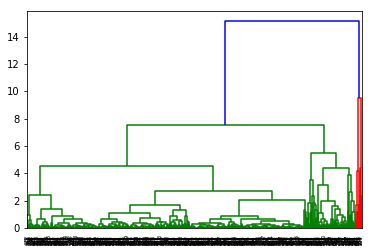

In [296]:
dn = dendrogram(distance_matrix)

Vemos que um bom número de clusters é 7

In [297]:
cluster_df["cluster_labels"] = fcluster(distance_matrix, 7, criterion="maxclust")

Observando a lista de cidades em cada cluster, vemos que o agrupamento está condizente com o que sabemos intuitivamente sobre as cidades. Utilizaremos essas referências para calcular modelos no nosso Dashboard.

In [311]:
cluster_reference = cluster_df[["municipio", "cluster_labels"]]

## Dump da base de dados agregada para clusterização

In [312]:
cluster_reference.to_csv("../data/generated/clusterized_cities.csv", encoding="windows-1254")